In [125]:
import numpy as np
import random as rand
import random
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from scipy import stats
from dataclasses import dataclass
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Constants

$\texttt{N}$ $\rightarrow$ constant for biomass decay for different terrain types \
$\texttt{B}$ $\rightarrow$ constant for lower and upper bounds of initial biomass \
$\texttt{M_CONST}$ $\rightarrow$ biomass decay constant \
$\texttt{ENV_SIZE}$ $\rightarrow$ dimension of environment \
$\texttt{TIME}$ $\rightarrow$ Number of time steps to simulate \
$\texttt{J, K}$ $\rightarrow$ $L(B)$ constants

In [2]:
N_n = 0.15
N_h = 0.1
N_l = 0.2
B_n_lower, B_n_upper = 10., 11.
B_h_lower, B_h_upper = 5., 6.
B_l_lower, B_l_upper = 3., 4.
M_CONST = 0.25
ENV_SIZE = 1000
TIME = 100
J = 0.5
K = 0.3

## Cell Information

Biomass $\textit{biomass: float} \rightarrow$ The amount of biomass at a particular cell \
Burn Status $\textit{on_fire: bool} \rightarrow$ Whether or not a particular cell is burning

In [3]:
@dataclass
class Cell:
    """Class for keeping track of an information in a cell."""
    curr_biomass: float
    max_biomass: float
    on_fire: bool
    is_burnt: bool
    N: float
    B: float
        
    def __init__(self, curr_biomass=0.0, on_fire=False, is_burnt=False):
        self.curr_biomass = curr_biomass
        self.max_biomass = 11.0 if isinstance(self, Normal) else 6.0 if isinstance(self, HRB) else 4.0
        self.N = N_n if isinstance(self, Normal) else N_h if isinstance(self, HRB) else N_l
        self.B = random.uniform(B_n_lower, B_n_upper) if isinstance(self, Normal)  \
                    else random.uniform(B_h_lower, B_h_upper) if isinstance(self, HRB) \
                    else random.uniform(B_l_lower, B_l_upper)
        self.on_fire = on_fire
        self.is_burnt = is_burnt
    
    def can_burn(self):
        return self.curr_biomass == 0 
    
    def decay_biomass(self):
        nxt = self.curr_biomass - (self.N * self.curr_biomass + M_CONST)
        self.curr_biomass = nxt if nxt > 0 else 0.0
        if self.curr_biomass == 0:
            self.on_fire = False
            self.is_burnt = True
    
    def set_fire(self):
        self.on_fire = True
        
    def n_t(self):
        pass
    
    def l_b(self):
        return (self.curr_biomass / self.max_biomass) * J + K

class Normal(Cell):
    """Normal cell class"""
    def n_t(self):
        return random.choices(population=[0, 1, 2], weights=[0.85, 0.13, 0.02])[0]

class HRB(Cell):
    """HRB cell class""" 
    def n_t(self):
        return random.choices(population=[0, 1, 2], weights=[0.9, 0.09, 0.01])[0]
    
class Log(Cell):
    """Logged cell class"""
    def n_t(self):
        return random.choices(population=[0, 1, 2], weights=[0.5, 0.35, 0.15])[0]

Test Cell Types

In [4]:
a = Log(curr_biomass = 5, on_fire=False)
a.n_t()

0

## Skewed F Distribution 

Taken from user B. Poe, generates a skewed distribution with parameterized mean, standard deviation, skew

/Users/benjaminshih/opt/miniconda3/envs/dataopen/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/benjaminshih/opt/miniconda3/envs/dataopen/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


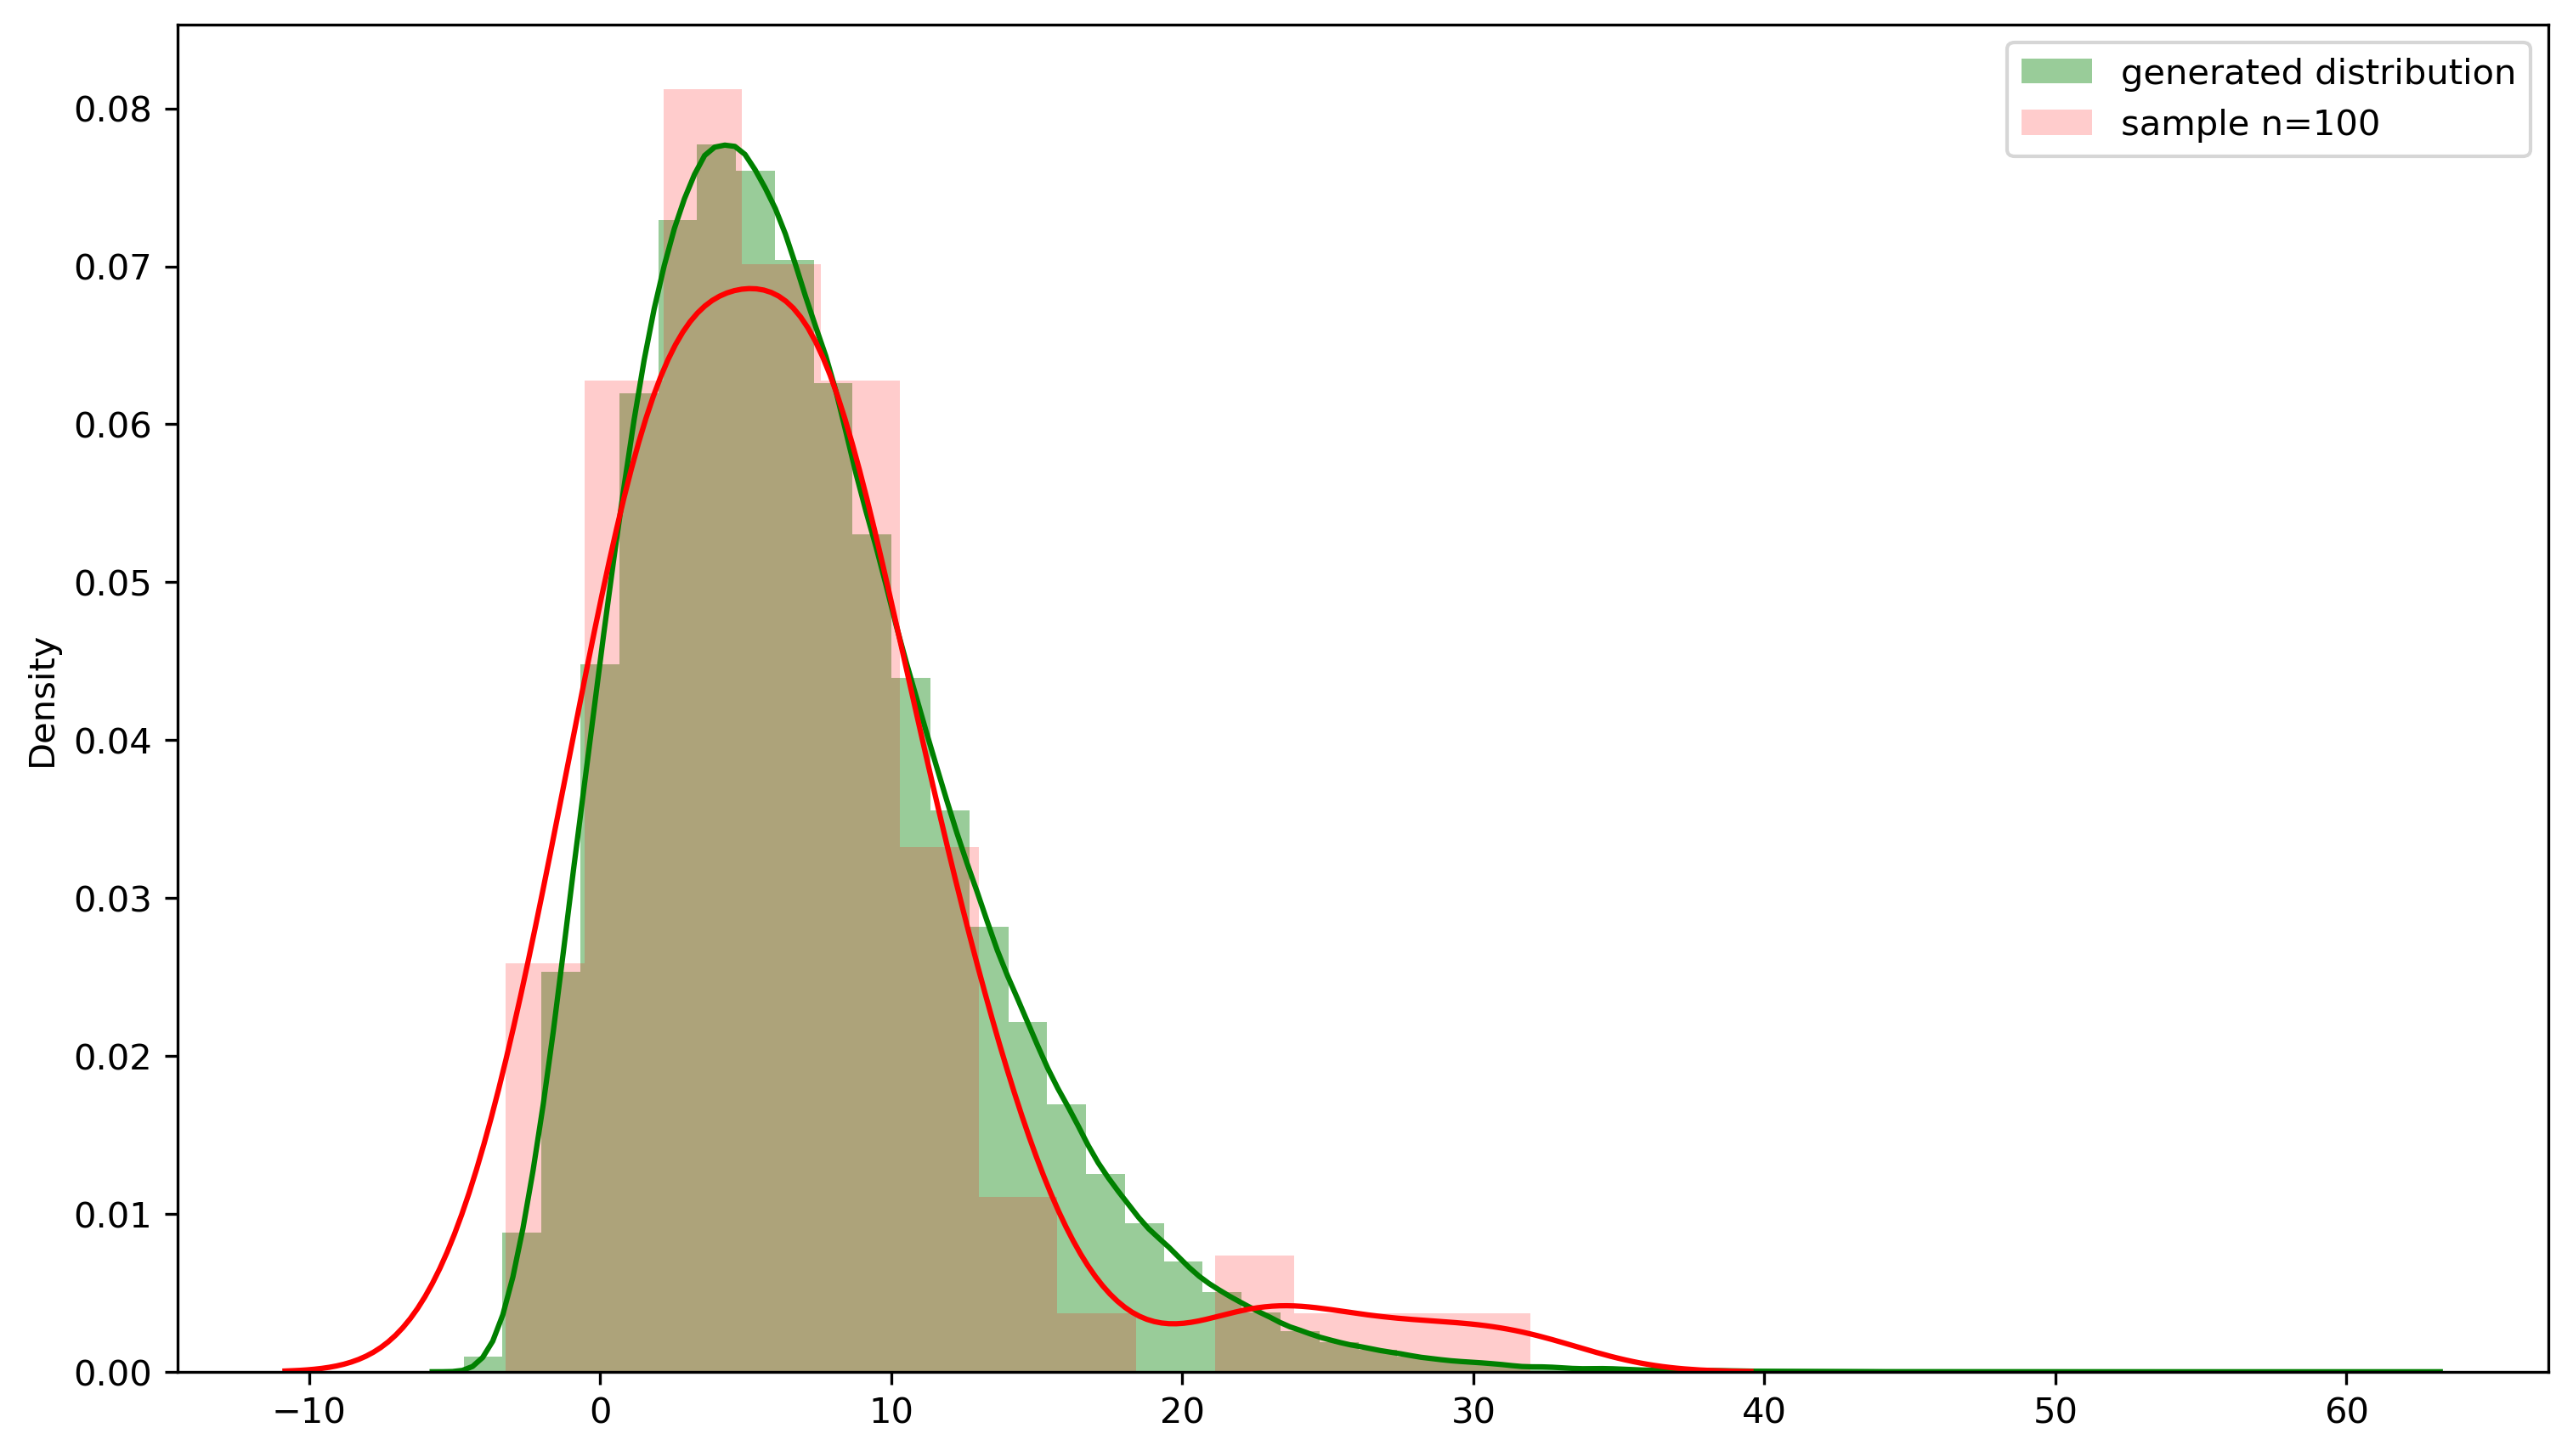

In [5]:
def createSkewDist(mean, sd, skew, size):

    # calculate the degrees of freedom 1 required to obtain the specific skewness statistic, derived from simulations
    loglog_slope=-2.211897875506251 
    loglog_intercept=1.002555437670879 
    df2=500
    df1 = 10**(loglog_slope*np.log10(abs(skew)) + loglog_intercept)

    # sample from F distribution
    fsample = np.sort(stats.f(df1, df2).rvs(size=size))

    # adjust the variance by scaling the distance from each point to the distribution mean by a constant, derived from simulations
    k1_slope = 0.5670830069364579
    k1_intercept = -0.09239985798819927
    k2_slope = 0.5823114978219056
    k2_intercept = -0.11748300123471256

    scaling_slope = abs(skew)*k1_slope + k1_intercept
    scaling_intercept = abs(skew)*k2_slope + k2_intercept

    scale_factor = (sd - scaling_intercept)/scaling_slope    
    new_dist = (fsample - np.mean(fsample))*scale_factor + fsample

    # flip the distribution if specified skew is negative
    if skew < 0:
        new_dist = np.mean(new_dist) - new_dist

    # adjust the distribution mean to the specified value
    final_dist = new_dist + (mean - np.mean(new_dist))

    return final_dist

desired_mean = 7
desired_skew = 1.05
desired_sd = 6

final_dist = createSkewDist(mean=desired_mean, sd=desired_sd, skew=desired_skew, size=1000000)
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(final_dist, hist=True, ax=ax, color='green', label='generated distribution')
sns.distplot(np.random.choice(final_dist, size=100), hist=True, ax=ax, color='red', hist_kws={'alpha':.2}, label='sample n=100')
ax.legend()
fig = ax.get_figure()
fig.savefig('f_distribution.png')

In [121]:
TYPES = [HRB, Normal, Log]

class Env:
    """Environment class"""
    size: int
    max_time: int
        
    def __init__(self, size: int, max_time=100, map_type="", plotting=True):
        self.size = size
        self.map = np.array([[Normal(curr_biomass=random.uniform(B_n_lower, B_n_upper), on_fire=False) \
                          if i < self.size//2 else Log(curr_biomass=random.uniform(B_h_lower, B_h_upper), \
                                                       on_fire=False) for i in range(self.size)] \
                               for _ in range(self.size)], dtype=object) if map_type == "nlcomp" \
        else np.array([[Normal(curr_biomass=random.uniform(B_n_lower, B_n_upper), on_fire=False) \
                              for _ in range(self.size)] \
                              for _ in range(self.size)], dtype=object) if map_type == "nflat" \
        else np.array([[HRB(curr_biomass=random.uniform(B_h_lower, B_h_upper), on_fire=False) \
                              for _ in range(self.size)] \
                              for _ in range(self.size)], dtype=object) if map_type == "hflat" \
        else np.array([[Log(curr_biomass=random.uniform(B_l_lower, B_l_upper), on_fire=False) \
                              for _ in range(self.size)] \
                              for _ in range(self.size)], dtype=object) if map_type == "lflat" \
        else np.array([[random.choice(TYPES)(curr_biomass=np.random.uniform(0, 50), on_fire=False) \
                              for _ in range(self.size)] \
                              for _ in range(self.size)], dtype=object)
        self.map[self.size//2, self.size//2].set_fire()
        #locations of currently burning cells
        self.curr_burn = set((i, j) for i in range(self.size) \
                              for j in range(self.size) if self.map[i, j].on_fire is True)
        self.max_time = max_time
        self.map_type = map_type
        self.burn_data = [len(self.curr_burn)]
        self.plotting = plotting
    
    def simulate(self):
        t = 1
        while t <= self.max_time:
            curr_add_burn = set() # keep current burned during a single tick in a set so no instantaneous burn
            #look at what's burning already since only those cells can change state
            for (i, j) in self.curr_burn:
                #check the adjacent cells to see if they're on fire and set fire
                #LOCAL SPREAD
                if (i - 1 >= 0) and not self.map[i - 1, j].on_fire  \
                and (i - 1, j) not in self.curr_burn: #left
                    set_fire_prob = self.map[i, j].l_b() / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i - 1, j))
                if (j - 1 >= 0) and not self.map[i, j - 1].on_fire  \
                and (i, j - 1) not in self.curr_burn: #top
                    set_fire_prob = self.map[i, j].l_b() / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i, j - 1))
                if (i + 1 < self.size) and not self.map[i + 1, j].on_fire  \
                and (i + 1, j) not in self.curr_burn: #right
                    set_fire_prob = self.map[i, j].l_b() / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i + 1, j))     
                if (j + 1 < self.size) and not self.map[i, j + 1].on_fire  \
                and (i, j + 1) not in self.curr_burn: #bottom
                    set_fire_prob = self.map[i, j].l_b() / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i, j + 1))
                        
                #NONLOCAL SPREAD
                num_nonlocal = self.map[i, j].n_t()
                for k in range(num_nonlocal):
                    man_dist = math.floor(abs(np.random.choice(final_dist)))
                    x = random.randint(0, man_dist)
                    y = man_dist - x
                    sign = random.randint(0, 3)
                    if sign == 0 and (i + x < self.size) and (j + y < self.size):
                        curr_add_burn.add((i + x, j + y))
                    elif sign == 1 and (i + x < self.size) and (j + y >= 0):
                        curr_add_burn.add((i + x, j - y))
                    elif sign == 2 and (i - x >= 0) and (j + y < self.size):
                        curr_add_burn.add((i - x, j + y))
                    else:
                        if (i - x >= 0) and (j - y >= 0):
                            curr_add_burn.add((i - x, j - y))
                
            #update current burning
            self.burn_data.append(self.burn_data[-1] + len(curr_add_burn))
            for (i, j) in curr_add_burn:
                self.map[i, j].set_fire()
                self.curr_burn.add((i, j))
            
            for (i, j) in self.curr_burn:
                self.map[i, j].decay_biomass()
            
            if self.plotting is True:
            
                if t % 10 == 0 or t == 1:
                    self.plot_simulations(t=t, plot_type="biomass")
                    print("Saving map for: " + self.map_type + " @ t = " + str(t))

                if t == self.max_time:
                    self.plot_burnt()
                    print("Saving burn graph for: " + self.map_type)
            
            t += 1
    
    def get_burn_data(self):
        return self.burn_data
    
    def populate_state(self, plot_type="terrain"):
        ret = np.array([[0 for _ in range(self.size)] for _ in range(self.size)])
        if plot_type == "burn":
            for i in range(self.size):
                for j in range(self.size):
                    if self.map[i, j].on_fire:
                        ret[i, j] = 0
                    else:
                        ret[i, j] = 1
        elif plot_type =="biomass":
            for i in range(self.size):
                for j in range(self.size):
                    if isinstance(self.map[i, j], Normal):
                        ret[i, j] = 0
                    elif isinstance(self.map[i, j], HRB):
                        ret[i, j] = 1
                    elif isinstance(self.map[i, j], Log):
                        ret[i, j] = 2
                    if self.map[i, j].is_burnt:
                        ret[i, j] = 3
                    bm = self.map[i, j].curr_biomass
                    if self.map[i, j].on_fire:
                        if 0 < bm and bm <= 2:
                            ret[i, j] = 4
                        elif 2 < bm and bm <= 4:
                            ret[i, j] = 5
                        elif 4 < bm and bm <= 6:
                            ret[i, j] = 6
                        elif 6 < bm and bm <= 8:
                            ret[i, j] = 7
                        elif 8 < bm and bm <= 10:
                            ret[i, j] = 8
                        elif 10 < bm and bm <= 11:
                            ret[i, j] = 9         
                        
        else:
            for i in range(self.size):
                for j in range(self.size):
                    if isinstance(self.map[i, j], Normal):
                        ret[i, j] = 0
                    elif isinstance(self.map[i, j], HRB):
                        ret[i, j] = 1
                    elif isinstance(self.map[i, j], Log):
                        ret[i, j] = 2
        return ret
    
    def plot_simulations(self, t=0, plot_type="terrain"):
        curr_state = self.populate_state()
        terrain_colors = colors.ListedColormap(['#24422c', '#4a8a5b', '#aab560'])
        if plot_type == "burn":
            curr_state = self.populate_state("burn")
            terrain_colors = colors.ListedColormap(['#000000', '#4a8a5b'])
        elif plot_type == "biomass":
            curr_state = self.populate_state("biomass")
        from matplotlib.colors import LinearSegmentedColormap
        cmap_reds = plt.get_cmap('Reds')
        num_colors = 9
        col = ['#4a8a5b', '#24422c', '#97DB46', '#C5A7A5', '#f3c222', '#f7ae26', \
               '#ff7831', '#ff5737', '#e4514e']
        cmap = LinearSegmentedColormap.from_list('', col, num_colors)
        ax = sns.heatmap(curr_state, cmap=cmap, vmin=0, vmax=num_colors, square=True, cbar=False, \
                         xticklabels=False, yticklabels=False)
        plt.savefig("./images/" + self.map_type + "/t_" + str(t) + ".jpeg")
    
    def plot_burnt(self):
        x = list(range(self.max_time + 1))
        sns.set_style(style='whitegrid')
        ax = sns.lineplot(x=x, y=self.burn_data, color='#e4514e')
        ax.set(xlabel='Time', ylabel='Cells burnt')
        plt.xlim(0)
        plt.ylim(0)
        plt.savefig("./images/" + self.map_type + "/burn_plot" + ".jpeg")

In [ ]:
test = Env(ENV_SIZE, map_type="hflat", max_time=100, plotting=False)
test.simulate()
hrb_burn_data = test.get_burn_data()
test = Env(ENV_SIZE, map_type="lflat", max_time=100, plotting=False)
test.simulate()
log_burn_data = test.get_burn_data()
test = Env(ENV_SIZE, map_type="nflat", max_time=100, plotting=False)
test.simulate()
norm_burn_data = test.get_burn_data()
t = list(range(10 + 1))
burn_data = pd.DataFrame()
burn_data['Time'] = t
burn_data['HRB'] = hrb_burn_data
burn_data['Log'] = log_burn_data
burn_data['Norm'] = norm_burn_data

sns.set_style(style='whitegrid')
ax = sns.lineplot(x='Time', data=pd.melt(burn_data, ['Time'], var_name='Terrain', value_name='Cells Burnt'), \
                  y='Cells Burnt', hue='Terrain', palette=['#ff7831', '#ff5737','#e4514e'])
ax.set(xlabel='Time', ylabel='Cells burnt')
ax.set_yscale('log')
plt.xlim(0)
plt.ylim(0)
plt.savefig("./images/burn_comparison.jpeg")

In [ ]:
test = Env(ENV_SIZE, map_type="hflat", max_time=10)
test.simulate()

## Simulations on Preset Environment Generations

To show effectiveness and compare different anti-wildfire techniques

Saving map for: nflat @ t = 1
Saving map for: nflat @ t = 10
Saving map for: nflat @ t = 20
Saving map for: nflat @ t = 30
Saving map for: nflat @ t = 40
Saving map for: nflat @ t = 50
Saving map for: nflat @ t = 60
Saving map for: nflat @ t = 70
Saving map for: nflat @ t = 80
Saving map for: nflat @ t = 90
Saving map for: nflat @ t = 100


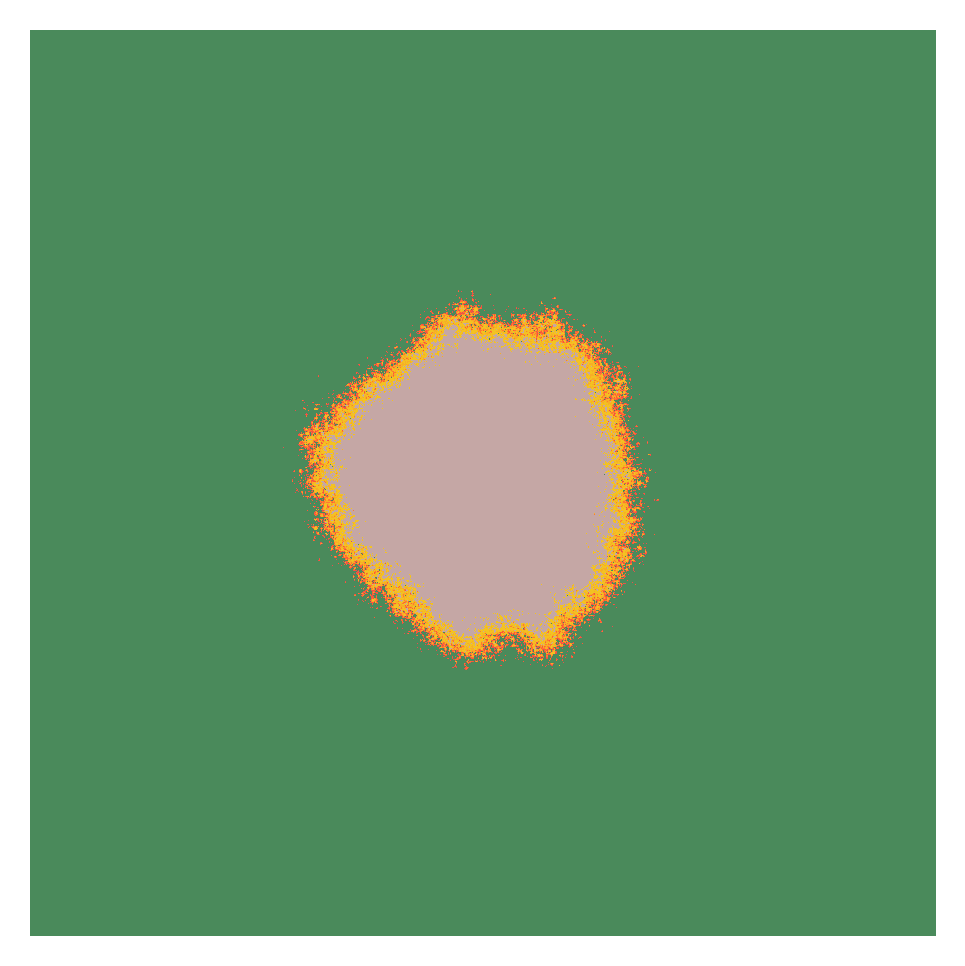

In [10]:
#normal terrain only
nflat = Env(ENV_SIZE, map_type="nflat")
nflat.simulate()

Saving map for: hflat @ t = 1
Saving map for: hflat @ t = 10
Saving map for: hflat @ t = 20
Saving map for: hflat @ t = 30
Saving map for: hflat @ t = 40
Saving map for: hflat @ t = 50
Saving map for: hflat @ t = 60
Saving map for: hflat @ t = 70
Saving map for: hflat @ t = 80
Saving map for: hflat @ t = 90
Saving map for: hflat @ t = 100


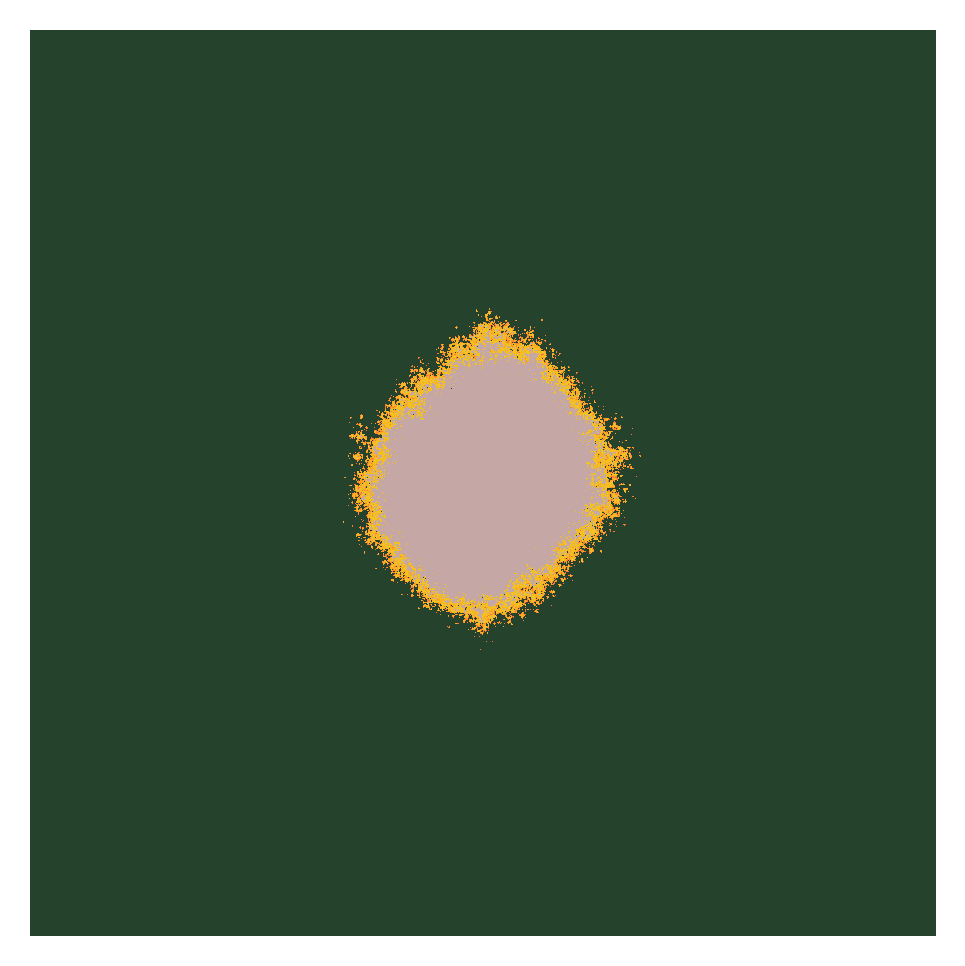

In [11]:
#HRB terrain only
hflat = Env(ENV_SIZE, map_type="hflat")
hflat.simulate()

Saving map for: lflat @ t = 1
Saving map for: lflat @ t = 10
Saving map for: lflat @ t = 20
Saving map for: lflat @ t = 30
Saving map for: lflat @ t = 40
Saving map for: lflat @ t = 50
Saving map for: lflat @ t = 60
Saving map for: lflat @ t = 70
Saving map for: lflat @ t = 80
Saving map for: lflat @ t = 90
Saving map for: lflat @ t = 100


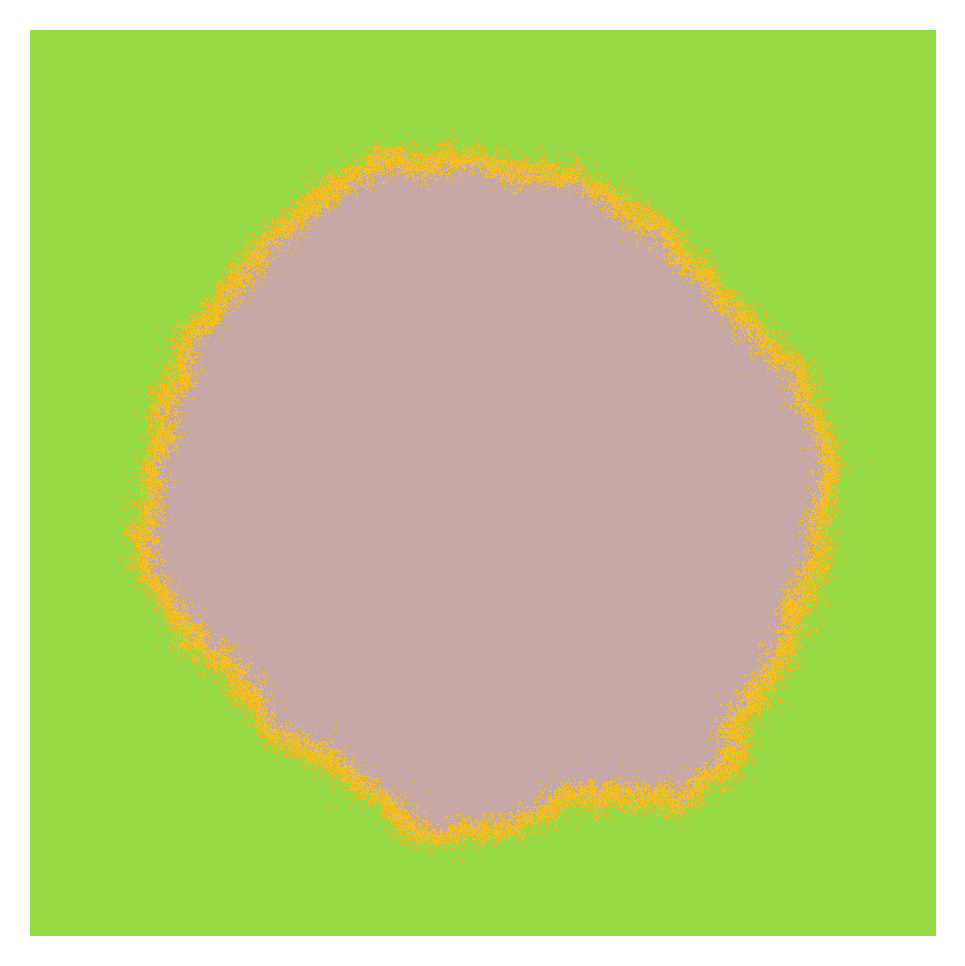

In [12]:
#logged terrain only
lflat = Env(ENV_SIZE, map_type="lflat")
lflat.simulate()

Saving map for: nflat @ t = 1
Saving map for: nflat @ t = 10
Saving map for: nflat @ t = 20
Saving burn graph for: nflat


/var/folders/qg/9kg66y8d15b3k1z_yvwhk7y80000gn/T/ipykernel_26225/4249668854.py:170: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0)


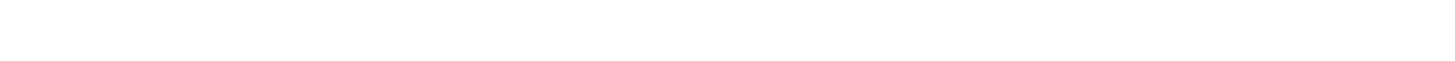

In [110]:
#Close ups of spotting
close_up = Env(100, map_type="nflat", max_time=20)
close_up.simulate()